In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
directory = "/content/drive/Othercomputers/Iliya-PC/GrayPhoto"
input_dir = os.path.join(directory, "train")
input_img_paths = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in input_img_paths])

print("Number of samples:", len(input_img_paths))

Number of samples: 185


(3000, 4000, 3)


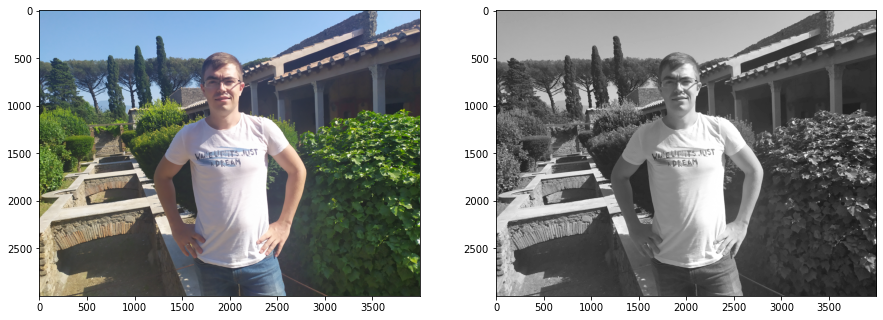

In [7]:
idx = 120

img = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2RGB)
grey = cv2.cvtColor(cv2.imread(input_img_paths[idx]), cv2.COLOR_BGR2GRAY)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(grey, cmap='gray')

print(img.shape)

In [9]:
# Data generator
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

class PhotoGenerator(keras.utils.Sequence):    
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to **batch** index."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img_gray = load_img(path, target_size=self.img_size + (1,), color_mode="grayscale")
            x[j] = np.expand_dims(img_gray, 2)
            img = load_img(path, target_size=self.img_size)
            y[j] = img
            
        return x/255, y/255
    
    def on_epoch_end(self):
        self.input_img_paths = shuffle(self.input_img_paths)

In [10]:
img_size = (320, 320)
batch_size = 32
samples = len(input_img_paths)

In [11]:
#Using U-Net architecture 

def get_U_model(img_size):
    # inputs = layers.Input(shape=img_size + (3,))
    inputs = layers.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add output layer with sigmoid activation function (result between 0 and 1)
    # outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
    # outputs = tf.nn.depth_to_space(x, 3)
    outputs = layers.Conv2DTranspose(3, 5, activation="sigmoid", padding="same", data_format="channels_last")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


# Build model
# model = get_model(img_size)
# model.summary()

In [12]:
model = get_U_model(img_size)
model.summary()
# plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
import random

# Split our img paths into a training and a validation set
val_samples = int(round(samples*0.2, 0))
random.Random(1337).shuffle(input_img_paths)

# Split data
train_input_img_paths = input_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]

# Instantiate data generators
train_gen = PhotoGenerator(batch_size, img_size, train_input_img_paths)
val_gen = PhotoGenerator(batch_size, img_size, val_input_img_paths)

In [14]:
model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError())
# callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
4/4 [==============================] - 134s 30s/step - loss: 0.1784 - val_loss: 0.3555
Epoch 2/15
4/4 [==============================] - 75s 20s/step - loss: 0.1386 - val_loss: 0.3581
Epoch 3/15
4/4 [==============================] - 66s 17s/step - loss: 0.1383 - val_loss: 0.3518
Epoch 4/15
4/4 [==============================] - 65s 17s/step - loss: 0.1355 - val_loss: 0.3370
Epoch 5/15
4/4 [==============================] - 63s 17s/step - loss: 0.1283 - val_loss: 0.3144
Epoch 6/15
4/4 [==============================] - 67s 17s/step - loss: 0.1222 - val_loss: 0.2813
Epoch 7/15
4/4 [==============================] - 65s 17s/step - loss: 0.1097 - val_loss: 0.2194
Epoch 8/15
4/4 [==============================] - 64s 17s/step - loss: 0.0961 - val_loss: 0.1975
Epoch 9/15
4/4 [==============================] - 66s 17s/step - loss: 0.0854 - val_loss: 0.1744
Epoch 10/15
4/4 [==============================] - 62s 17s/step - loss: 0.0718 - val_loss: 0.1425
Epoch 11/15
4/4 [===========

In [15]:
val_gen = PhotoGenerator(batch_size, img_size, val_input_img_paths)
val_preds = model.predict(val_gen)

1/1 [==============================] - 12s 12s/step


(<matplotlib.axes._subplots.AxesSubplot at 0x7feeec0b3e80>,
 <matplotlib.image.AxesImage at 0x7feeec0990d0>)

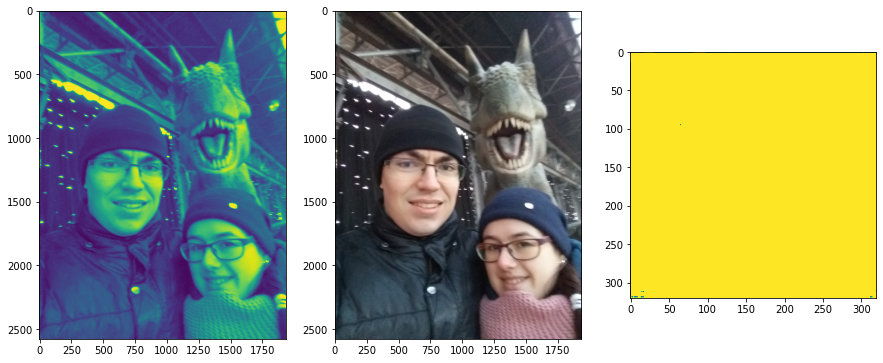

In [16]:
idx = 10

x = load_img(val_input_img_paths[idx], color_mode="grayscale")
y_true = load_img(val_input_img_paths[idx])
y_pred = np.argmax(val_preds[idx], axis=-1)

plt.subplot(131), plt.imshow(x)
plt.subplot(132), plt.imshow(y_true)
plt.subplot(133), plt.imshow(y_pred)

In [19]:
np.shape(y_pred)

(320, 320)